# Homework 7

## Problem 8 - SVM

In this problem we have to compare the performance of PLA and SVM. In this notebook we will use the `cvxopt` quadratic programming solver to train the support vector machine.

## Class `SVM_cvxopt`

In [1]:
import cvxopt



class SVM_cvxopt:
    
    def __init__(self):
        self.num_support_vectors_ = None
        self.w_ = None
        self.intercept_ = None
        self.support_vectors_ = None
        self.alpha_ = None
        
    
    def fit(self, X, y):
        '''
        - Takes data X and labels y
        - Calculates weight vector
        '''
        N = X.shape[0]
        YY = np.dot(y.reshape(N,1),y.reshape(1,N))
        XX = np.dot(X, X.T)

        # http://cvxopt.org/examples/tutorial/qp.html
        # tell program that the alpha_i (Lagrange multipliers) are nonnegative
        G = cvxopt.matrix(-np.identity(N), tc='d')
        h = cvxopt.matrix(np.zeros(N), tc='d')

        P = cvxopt.matrix(YY * XX, tc='d')
        q = cvxopt.matrix(-np.ones(N), tc='d')
        A = cvxopt.matrix(y, tc='d').T
        b = cvxopt.matrix(np.zeros(1), tc='d')

        from cvxopt import solvers
        # https://stackoverflow.com/questions/26416626/how-to-silent-cvxopt-solver-python
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        
        # alpha vector (see lecture, Lagrange multipliers)
        # https://stackoverflow.com/questions/3337301/numpy-matrix-to-array
        self.alpha_ = np.asarray(sol['x']).reshape(-1)
        n = self.alpha_.shape[0]
        
        # vector w
        self.w_ = np.zeros(X.shape[1])
        for i in range(n):
            self.w_ = self.w_ + y[i] * self.alpha_[i] * X[i]
            
        # number of support vectors is the number of non-zero entries in alpha
        # The threshold for counting a support vector is here set to 10**(-4).
        # You may try other values.
        self.num_support_vectors_ = sum(self.alpha_ > 10**(-4))
        
        # support vectors
        self.indices_ = (self.alpha_ > 10**(-4)).nonzero()[0]    # count boolean true values
        # https://stackoverflow.com/questions/3337301/numpy-matrix-to-array
        self.support_vectors_ = np.asarray(X[self.indices_]).reshape(-1)
        
        # intercept
        self.intercept_ = 1/y[self.indices_[0]] - np.dot(self.w_, X[self.indices_[0]])
        

**Note**:

The threshold for counting a support vector was here set to $10^{-4}$ in the class above. If you set this value too low, then you will count too many points as support vectors, e.g. if you have an entry of $10^{-6}$ in the $\alpha$ vector, do you count it as support vector or not?

If you set your threshold to $10^{-8}$, then you count that point as a support vector, whereas for a threshold of $10^{-4}$ you don't count it as support vector.

Try it yourself, change the threshold and compare the number of support vectors you get with the scikit learn (libsvm) implementation.

## 8.1 Import libraries

In [2]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt


## 8.2 Implement PLA

In [3]:
def PLA(Z, y_f):
    '''
    - Takes 
      Z: feature matrix, 
      y_f: labels by target function f
    - Returns weight vector w using the perceptron learning algorithm 
    '''
    
    num_features =  Z.shape[1]
    w_h = np.zeros(num_features)                    # initialize weight vector for hypothesis h
    t = 0                                           # count number of iterations in PLA
    
    while True:
        # Start PLA
        y_h = np.sign(np.dot(Z, w_h))               # classification by hypothesis
        comp = (y_h != y_f)                         # compare classification with actual data from target function
        wrong = np.where(comp)[0]                   # indices of points with wrong classification by hypothesis h

        if wrong.size == 0:
            break
        
        rnd_choice = np.random.choice(wrong)        # pick a random misclassified point

        # update weight vector (new hypothesis):
        w_h = w_h +  y_f[rnd_choice] * np.transpose(Z[rnd_choice])
        t += 1
        if t == 10**3:
            break
    
    return w_h

# 8.3 Implement target function $f$

The target function $f$ is used to generate our training and test data.

In [4]:
def get_target_function():
    '''
    - Returns weight vector w_f defining target function
      which is a line through points A and B
    '''
    # return vector of n points from the interval [-1,1]
    rnd = lambda n: np.random.uniform(-1,1,n)
    
    # choose two random points A, B in [-1,1] x [-1,1]
    A = rnd(2)
    B = rnd(2)

    # the line can be described by y = m*x + b where m is the slope
    # the subscript f indicats that this is the target function f
    m = (B[1] - A[1]) / (B[0] - A[0])
    b = B[1] - m * B[0]  
    w_f = np.array([b, m, -1])                    # weight vector

    return w_f

#-------------------------------

def get_target_labels(Z, w_f):
    '''
    - Takes feature matrix Z
    - Takes weight vector w_f of target function
    - Returns labels by target function f
    '''
    return np.sign(np.dot(Z, w_f))

#-------------------------------

def get_random_points(N):
    '''
    - Takes number of parameters N 
    - Returns tuple (x1, x2), where x1 and x2 are vectors
    '''
    x1 = np.random.uniform(-1,1,N)
    x2 = np.random.uniform(-1,1,N)
    return (x1, x2)

In [5]:
def weight_to_line(w):
    '''
    - Takes weight vector w
    - Returns slope m and intercept b of line
    
    We know that w^T x = 0 for points (x1,x2) on the line, so
    w0 * 1 + w1 * x1 + w2 * x2 = 0
    w0     + w1 * x1 + w2 * x2 = 0
    
    Let's solve for x2:
        w2 * x2 = -w0 - w1*x1
    =>       x2 = -(w0/w2) + (-w1/w2) * x1
    
    This is the equation of a line x2 = b + m*x1.
    The intercept is b = -(w0/w2),
    the slope is m = -w1/w2
    
    Let's return both
    '''
    b = -(w[0] / w[2])
    m = -(w[1] / w[2])
    
    return b, m

In [6]:
def predict(Z_test, w):
    '''
    - Takes feature matrix Z_test
    
    - Takes weight vector obtained from final hypothesis g
      (learned model).
      
    - Returns classification vector y via sign of 
      linear classifier sign(w^T z)
    '''
    y = np.sign(np.dot(Z_test, w))
    return y


def get_error(y_test, y_predict):
    '''
    - Takes labels of test set y_test (true labels)
    - Takes predicted labels (classifications) by model
    - Returns error, i.e. fraction of points whose predicted label does not equal
      the true label
    '''
    N_test = y_test.shape[0]
    return np.sum(y_test != y_predict) / N_test

## 8.4 Comparison of PLA and SVM

For 1000 runs we:

- generate a training set of 10 points.
- train a classifier via PLA.
- train a classifier via SVM.
- generate 1000 test points
- compute the out-of-sample classification error of PLA and SVM respectively.
- count the number of times SVM yields a lower classification error than PLA.

### 8.4.1 Implementation of runs

In [7]:
def problem_8(N_train, RUNS=1000, SHOW_PLOT_TRAIN=False, SHOW_PLOT_TEST=False, PRINT_ERRORS=False):
    #RUNS = 1000
    iteration = RUNS
    
    # N_train = 10
    N_test = 1000
    
    #SHOW_PLOT_TRAIN = False
    #SHOW_PLOT_TEST = False
    #PRINT_ERRORS = False
    
    E_test_PLA_total = 0
    E_test_SVM_total = 0
    SVM_better_than_PLA_total = 0
    num_SVM_vectors_total = 0
    
    while iteration:
    
        #----------------------------------
        
        # TRAINING
        x1_train, x2_train = get_random_points(N_train)
        
        # feature matrix for training set
        Z_train = np.c_[np.ones(N_train), x1_train, x2_train]
        
        # weight vector of target function f
        w_f = get_target_function()
        
        # labels by target function f
        y_train = get_target_labels(Z_train, w_f)
    
        # discard if all classified the same
        if abs(sum(y_train)) == N_train:
            continue
        
        # PLA-------------------------------
        w_PLA = PLA(Z_train, y_train)
        
        #----------------------------------
        
        # SVM classifier clf
        clf = SVM_cvxopt()
        clf.fit(Z_train[:, 1:], y_train)
        
        w_SVM = np.array(3*[None])
        w_SVM[1], w_SVM[2] = clf.w_ 
        w_SVM[0] = clf.intercept_
        num_SVM_vectors = clf.num_support_vectors_
        
        num_SVM_vectors_total += num_SVM_vectors
        
        # Computing error on in-sample training set
        # this error should be zero ! This is a check.
        # predictions
        predict_PLA_train = predict(Z_train, w_PLA)
        predict_SVM_train = predict(Z_train, w_SVM)
        E_in_PLA = get_error(y_train, predict_PLA_train)
        E_in_SVM = get_error(y_train, predict_SVM_train)
        
        #----------------------------------
        #----------------------------------
        
        # TESTING
        x1_test, x2_test = get_random_points(N_test)
        
        # feature matrix for training set
        Z_test = np.c_[np.ones(N_test), x1_test, x2_test]
        
        # labels by target function f
        y_test = get_target_labels(Z_test, w_f)
        
        # predictions
        predict_PLA = predict(Z_test, w_PLA)
        predict_SVM = predict(Z_test, w_SVM)
        
        # errors
        E_test_PLA = get_error(y_test, predict_PLA)
        E_test_SVM = get_error(y_test, predict_SVM)
        
        E_test_PLA_total += E_test_PLA
        E_test_SVM_total += E_test_SVM
        
        #print("E_test_PLA = ", E_test_PLA)
        #print("E_test_SVM = ", E_test_SVM)
        
        SVM_better_than_PLA_total += (E_test_SVM < E_test_PLA)
        
        if PRINT_ERRORS:
            print("E_in_PLA = ", E_in_PLA)
            print("E_in_SVM = ", E_in_PLA)
            print("E_test_PLA = ", E_test_PLA)
            print("E_test_SVM = ", E_test_SVM)
        
        #----------------------------------
        
        if SHOW_PLOT_TRAIN:
            print("\nShowing plot for training set:")
            
            # plot points classified by target function f
            plt.scatter(x1_train[y_train==1], x2_train[y_train==1], color='lightsteelblue')
            plt.scatter(x1_train[y_train==-1], x2_train[y_train==-1], color='lightpink')

            # points on the line of the target function
            intercept, slope = weight_to_line(w_f)
            A = [-1, intercept + slope*(-1)]
            B = [1, intercept + slope*(1)]
            plt.plot([A[0], B[0]], [A[1], B[1]], 'g', label='Target')

            # points on the line of the PLA hypothesis
            intercept_PLA, slope_PLA = weight_to_line(w_PLA)
            A_PLA = [-1, intercept_PLA + slope_PLA*(-1)]
            B_PLA = [1, intercept_PLA + slope_PLA*(1)]
            plt.plot([A_PLA[0], B_PLA[0]], [A_PLA[1], B_PLA[1]], 'b:', label='PLA')

            # points on the line of the SVM hypothesis
            intercept_SVM, slope_SVM = weight_to_line(w_SVM)
            A_SVM = [-1, intercept_SVM + slope_SVM*(-1)]
            B_SVM = [1, intercept_SVM + slope_SVM*(1)]
            plt.plot([A_SVM[0], B_SVM[0]], [A_SVM[1], B_SVM[1]], 'r-.', label='SVM')
            
            #----------------------
            
            plt.xlim(-1,1)
            plt.ylim(-1,1)
        
            plt.xlabel('$x_1$')
            plt.ylabel('$x_2$')
            plt.title('Problem 8')
            plt.legend()
            plt.show()
            print('--')
            
        #----------------------------------
        
        if SHOW_PLOT_TEST:
            print("\nShowing plot for testing set:")
            
            # plot test points classified by target function f
            plt.scatter(x1_test[y_test==1], x2_test[y_test==1], color='lightsteelblue')
            plt.scatter(x1_test[y_test==-1], x2_test[y_test==-1], color='lightpink')

            # points on the line of the target function
            intercept, slope = weight_to_line(w_f)
            A = [-1, intercept + slope*(-1)]
            B = [1, intercept + slope*(1)]
            plt.plot([A[0], B[0]], [A[1], B[1]], 'g', label='Target')

            # points on the line of the PLA hypothesis
            intercept_PLA, slope_PLA = weight_to_line(w_PLA)
            A_PLA = [-1, intercept_PLA + slope_PLA*(-1)]
            B_PLA = [1, intercept_PLA + slope_PLA*(1)]
            plt.plot([A_PLA[0], B_PLA[0]], [A_PLA[1], B_PLA[1]], 'b:', label='PLA')

            # points on the line of the SVM hypothesis
            intercept_SVM, slope_SVM = weight_to_line(w_SVM)
            A_SVM = [-1, intercept_SVM + slope_SVM*(-1)]
            B_SVM = [1, intercept_SVM + slope_SVM*(1)]
            plt.plot([A_SVM[0], B_SVM[0]], [A_SVM[1], B_SVM[1]], 'r-.', label='SVM')
            
            #----------------------
            
            plt.xlim(-1,1)
            plt.ylim(-1,1)
        
            plt.xlabel('$x_1$')
            plt.ylabel('$x_2$')
            plt.title('Problem 8')
            plt.legend()
            plt.show()
            
            print('----------------------------------------------------')
            
        
        iteration -= 1
        
        
    E_test_PLA_avg = E_test_PLA_total / RUNS
    E_test_SVM_avg = E_test_SVM_total / RUNS
    SVM_better_than_PLA_avg = SVM_better_than_PLA_total / RUNS
    num_SVM_vectors_avg = num_SVM_vectors_total / RUNS
    
    return E_test_PLA_avg, E_test_SVM_avg, SVM_better_than_PLA_avg, num_SVM_vectors_avg
        
        

### 8.4.2 Computation and results

In [8]:
%%time
# print execution time of cell, has to be at the top of cell

# set N_train = 10
E_test_PLA_avg, E_test_SVM_avg, count_SVM_better_than_PLA, num_SVM_vectors_avg = problem_8(10)
print("E_test_PLA_avg = ", E_test_PLA_avg)
print("E_test_SVM_avg = ", E_test_SVM_avg)
print("count_SVM_better_than_PLA = ", count_SVM_better_than_PLA)

E_test_PLA_avg =  0.107877
E_test_SVM_avg =  0.089864
count_SVM_better_than_PLA =  0.637
Wall time: 3.6 s


### Result

In about $60\%$ of the runs SVM yields a lower out-of-sample classification error than PLA. Therefore, answer **8[c]** is correct.

# Problem 9 and 10

We repeat the experiment from Problem 8 for $N_{train} = 100$ training points 1000 runs and compute:

- the number of times SVM yields a lower out-of-sample classification error than PLA;
- the average number of support vectors for the SVM;

In [9]:
%%time
# print execution time of cell, has to be at the top of cell



N_train = 100
E_test_PLA_avg, E_test_SVM_avg, count_SVM_better_than_PLA, num_SVM_vectors_avg = problem_8(N_train)
print("E_test_PLA_avg = ", E_test_PLA_avg)
print("E_test_SVM_avg = ", E_test_SVM_avg)
print("\ncount_SVM_better_than_PLA = ", count_SVM_better_than_PLA)
print("num_SVM_vectors_avg = ", num_SVM_vectors_avg)

print("\nCheck inequality: \nE[num_SVM] >= (N-1) * E[E_out]")       # see slide 20, lecture 14
print(num_SVM_vectors_avg , " >= ", (N_train-1) * E_test_SVM_avg)

E_test_PLA_avg =  0.013339
E_test_SVM_avg =  0.010835

count_SVM_better_than_PLA =  0.587
num_SVM_vectors_avg =  3.02

Check inequality: 
E[num_SVM] >= (N-1) * E[E_out]
3.02  >=  1.072665
Wall time: 15.9 s


## Problem 9 - Results

In about $60\%$ of the runs SVM yields a lower out-of-sample classification error than PLA. Therefore, answer **9[d]** is correct.

## Problem 10 - Results

The average number of support vectors is 3. Therefore, answer **10[b]** is correct.

# Some plots of the decision boundaries for $N=10$ training points

E_in_PLA =  0.0
E_in_SVM =  0.0
E_test_PLA =  0.323
E_test_SVM =  0.218

Showing plot for training set:


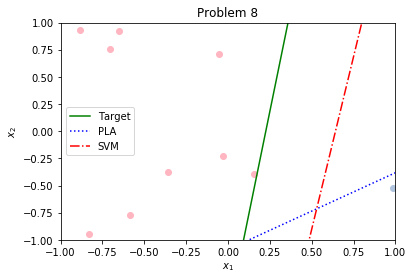

--

Showing plot for testing set:


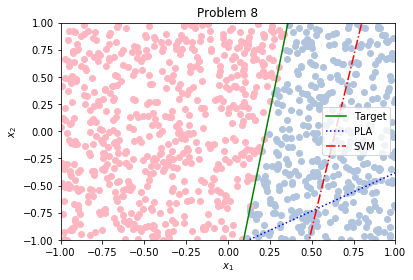

----------------------------------------------------
E_in_PLA =  0.0
E_in_SVM =  0.0
E_test_PLA =  0.082
E_test_SVM =  0.038

Showing plot for training set:


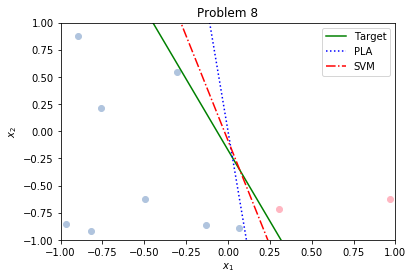

--

Showing plot for testing set:


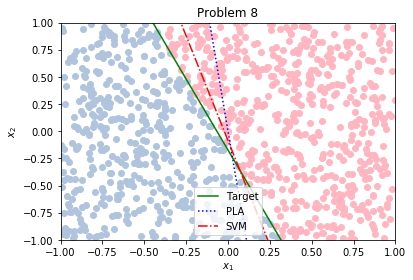

----------------------------------------------------
E_in_PLA =  0.0
E_in_SVM =  0.0
E_test_PLA =  0.056
E_test_SVM =  0.057

Showing plot for training set:


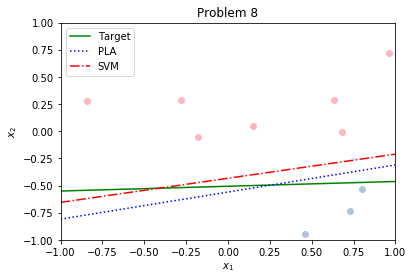

--

Showing plot for testing set:


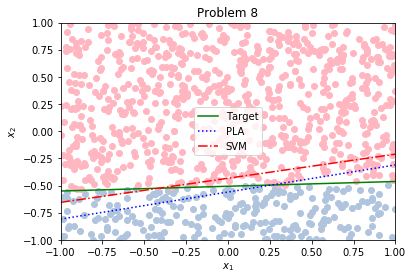

----------------------------------------------------
E_in_PLA =  0.0
E_in_SVM =  0.0
E_test_PLA =  0.062
E_test_SVM =  0.027

Showing plot for training set:


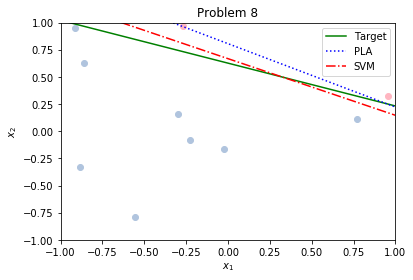

--

Showing plot for testing set:


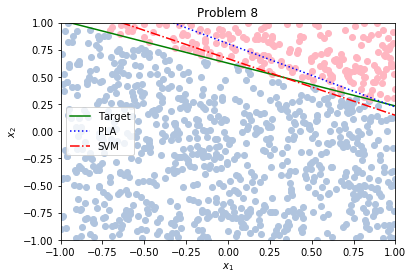

----------------------------------------------------
E_in_PLA =  0.0
E_in_SVM =  0.0
E_test_PLA =  0.187
E_test_SVM =  0.203

Showing plot for training set:


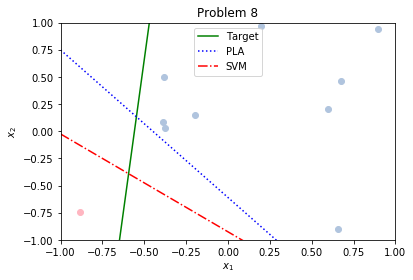

--

Showing plot for testing set:


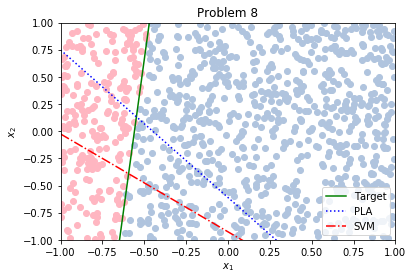

----------------------------------------------------
Wall time: 4.43 s


(0.14199999999999999, 0.1086, 0.59999999999999998, 2.6000000000000001)

In [10]:
%%time
# print execution time of cell, has to be at the top of cell

problem_8(N_train=10, RUNS=5, SHOW_PLOT_TRAIN=True, SHOW_PLOT_TEST=True, PRINT_ERRORS=True)